# Temas 

 Introducción

* Definiciones básicas 
* Métricas de calidad

Move, smoothe, evaluate

*   Rolling window estimations
*   Exponential smoothing, Holt-Winters model
*  Time-series cross validation, parameters selection


Enfoque econométrico

*  Stationarity, unit root

*  Getting rid of non-stationarity

*  SARIMA intuition and model building

Modelos lineales (y no tanto) en series de tiempo 

* Feature extraction

* Linear models, feature importance

* Regularization, feature selection

* XGBoost

In [1]:
import numpy as np                               
import pandas as pd                              
import matplotlib.pyplot as plt
import seaborn as sns

from scipy.optimize import minimize

from dateutil.relativedelta import relativedelta 

import statsmodels.formula.api as smf 
import statsmodels.tsa.api as smt
import statsmodels.api as sm
import scipy.stats as scs

from itertools import product                   
from tqdm import tqdm_notebook

import warnings
warnings.filterwarnings('ignore')

%matplotlib inline



Saving ads.csv to ads.csv


{'ads.csv': b'Time,Ads\r2017-09-13T00:00:00,80115\r2017-09-13T01:00:00,79885\r2017-09-13T02:00:00,89325\r2017-09-13T03:00:00,101930\r2017-09-13T04:00:00,121630\r2017-09-13T05:00:00,116475\r2017-09-13T06:00:00,106495\r2017-09-13T07:00:00,102795\r2017-09-13T08:00:00,108055\r2017-09-13T09:00:00,116125\r2017-09-13T10:00:00,131030\r2017-09-13T11:00:00,149020\r2017-09-13T12:00:00,157590\r2017-09-13T13:00:00,150715\r2017-09-13T14:00:00,149295\r2017-09-13T15:00:00,150100\r2017-09-13T16:00:00,144780\r2017-09-13T17:00:00,150690\r2017-09-13T18:00:00,163840\r2017-09-13T19:00:00,166235\r2017-09-13T20:00:00,139520\r2017-09-13T21:00:00,105895\r2017-09-13T22:00:00,96780\r2017-09-13T23:00:00,82520\r2017-09-14T00:00:00,80125\r2017-09-14T01:00:00,75335\r2017-09-14T02:00:00,85105\r2017-09-14T03:00:00,102080\r2017-09-14T04:00:00,125135\r2017-09-14T05:00:00,118030\r2017-09-14T06:00:00,109225\r2017-09-14T07:00:00,102475\r2017-09-14T08:00:00,102240\r2017-09-14T09:00:00,115840\r2017-09-14T10:00:00,130540\r2017

In [3]:
from google.colab import files
files.upload()

Saving currency.csv to currency.csv


{'currency.csv': b'Time,GEMS_GEMS_SPENT\r5/1/17,1199436\r5/2/17,1045515\r5/3/17,586111\r5/4/17,856601\r5/5/17,793775\r5/6/17,606535\r5/7/17,1112763\r5/8/17,1121218\r5/9/17,813844\r5/10/17,903343\r5/11/17,863465\r5/12/17,639224\r5/13/17,1030389\r5/14/17,1132645\r5/15/17,1018672\r5/16/17,1726870\r5/17/17,1378430\r5/18/17,532950\r5/19/17,828238\r5/20/17,823948\r5/21/17,592549\r5/22/17,939337\r5/23/17,862611\r5/24/17,551557\r5/25/17,878375\r5/26/17,784535\r5/27/17,613603\r5/28/17,1054658\r5/29/17,1026401\r5/30/17,682284\r5/31/17,986644\r6/1/17,924769\r6/2/17,633489\r6/3/17,1044957\r6/4/17,1088685\r6/5/17,798582\r6/6/17,1139786\r6/7/17,1066560\r6/8/17,754706\r6/9/17,1199406\r6/10/17,1186341\r6/11/17,958210\r6/12/17,1564553\r6/13/17,1470865\r6/14/17,1201275\r6/15/17,2418723\r6/16/17,2123070\r6/17/17,978338\r6/18/17,1536623\r6/19/17,1420586\r6/20/17,966259\r6/21/17,1232735\r6/22/17,1090762\r6/23/17,763828\r6/24/17,1153383\r6/25/17,1074039\r6/26/17,733943\r6/27/17,1103070\r6/28/17,1123779\r6/2

### conda install -c conda-forge ipywidgets

## Definiciones básicas

Trabajaremos con mobile game data. Específicamente, trabajaremos con los anuncios vistos por hora al igual que la in-game currency gastada por día.

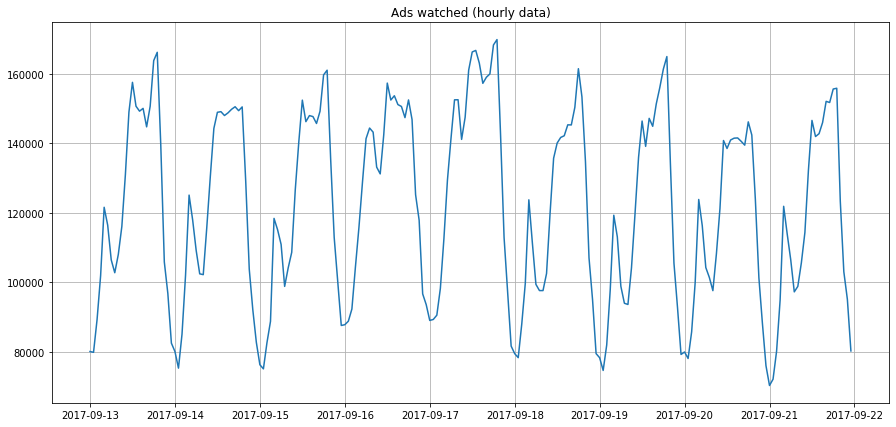

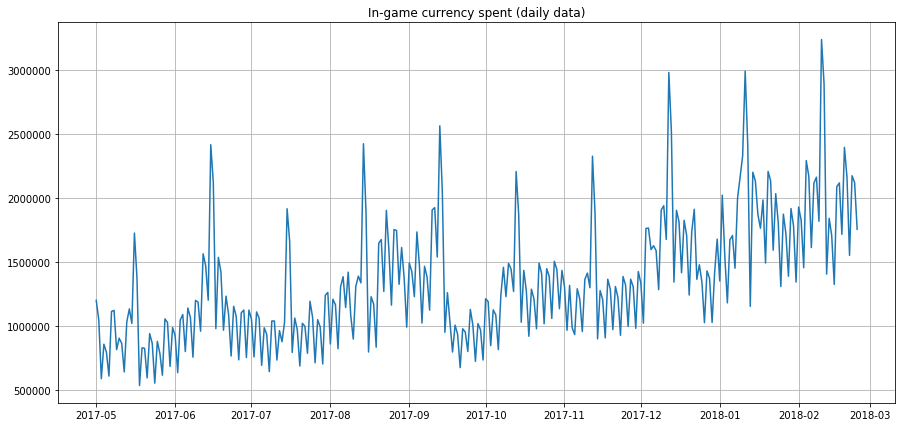

In [4]:
ads = pd.read_csv('ads.csv', index_col=['Time'], parse_dates=['Time'])
currency = pd.read_csv('currency.csv', index_col=['Time'], parse_dates=['Time'])

plt.figure(figsize=(15, 7))
plt.plot(ads.Ads)
plt.title('Ads watched (hourly data)')
plt.grid(True)
plt.show()

plt.figure(figsize=(15, 7))
plt.plot(currency.GEMS_GEMS_SPENT)
plt.title('In-game currency spent (daily data)')
plt.grid(True)
plt.show()

## Métricas de calidad

<h3><center> sklearn.metrics.r2_score </center></h3> 
$$ R^2 = 1 - \cfrac{SS_{res}}{SS_{tot}} $$

<h3><center> sklearn.metrics.mean_absolute_error</center></h3>  
$$ MAE =  \cfrac{ \sum_{i=1}^{n} y_{i} -\widehat{y}_i }{n}$$

<h3><center>  sklearn.metrics.median_absolute_error </center></h3>
$$ MedAE = median(|y_1 - \widehat{y}_i|,|y_2 - \widehat{y}_2|...,|y_n - \widehat{y}_n|) $$

<h3><center>  sklearn.metrics.mean_squared_error </center></h3>
$$MSE = \cfrac{1}{n} \sum_{i=1}^{n} (y_{i} -\widehat{y}_i)^2 $$

<h3><center> sklearn.metrics.mean_squared_log_error </center></h3>
$$ MSLE = \cfrac{1}{n} \sum_{i=1}^{n} (log(1 + y_{i}) - log(1 + \widehat{y}_i)) ^2 $$

<h3><center> MAPE (Mean Absolute Percentage Error) </center></h3>

$$ \cfrac{100}{n} \sum_{i=1}^{n}  \cfrac{|y_i - \widehat{y}_i|}{y_i} $$

In [0]:
from sklearn.metrics import r2_score, median_absolute_error, mean_absolute_error
from sklearn.metrics import median_absolute_error, mean_squared_error, mean_squared_log_error

def mean_absolute_percentage_error(y_true, y_pred): 
    return np.mean(np.abs((y_true - y_pred) / y_true)) * 100

## Move, Smooth, Evaluate

Empecemos con una hipótesis ingenua, que el futuro será igual que el presente. Sin embargo, en lugar de asumir que $y_t=y_t-1$ asumiremos que el valor futuro de la variable depende del promedio de los $k$ valores previos por lo que usaremos el promedio móvil.

$$ \widehat{y_t} =  \cfrac{1}{k} \sum_{n=0}^{k-1}y_{t-n}$$

In [6]:
def moving_average(series, n):
    """
        Devuelve el promedio de las ultimas n observaciones en la serie
    """
    return np.average(series[-n:])

# prediccion para el ultimo dia observado (ultimas 24 hr)
moving_average(ads, 24) 

116805.0

Desafortunadamente no podemos hacer predicciones distantes en el futuro, para obtener el valor del próximo paso necesitamos que los valores anteriores sean observados.  El promedio móvil tiene otro uso, suavizar la serie original. 
En Pandas    'DataFrame.rolling(window).mean(). '
Tenga en cuenta que cuanto más amplia la ventana más suave será la serie resultante. 

In [0]:
def plotMovingAverage(series, window, plot_intervals=False, scale=1.96, plot_anomalies=False):

    """
        series - dataframe c timeseries
        window - ventana movil de tiempo
        plot_intervals - grafica intervalos de confianza
        plot_anomalies - grafica anomalias
        
    """
    rolling_mean = series.rolling(window=window).mean()

    plt.figure(figsize=(15,5))
    plt.title("Media Móvil\n window size = {}".format(window))
    plt.plot(rolling_mean, "g", label="Rolling mean trend")

    # Plot confidence intervals for smoothed values
    if plot_intervals:
        mae = mean_absolute_error(series[window:], rolling_mean[window:])
        deviation = np.std(series[window:] - rolling_mean[window:])
        lower_bond = rolling_mean - (mae + scale * deviation)
        upper_bond = rolling_mean + (mae + scale * deviation)
        
        plt.plot(upper_bond, "r--", label="Limite Superior / Inferior IC", )
        plt.plot(lower_bond, "r--")
        
        # Having the intervals, find abnormal values
        if plot_anomalies:
            anomalies = pd.DataFrame(index=series.index, columns=series.columns)
            anomalies[series<lower_bond] = series[series<lower_bond]
            anomalies[series>upper_bond] = series[series>upper_bond]
            plt.plot(anomalies, "ro", markersize=10)
        
    plt.plot(series[window:], label="Actual values")
    plt.legend(loc="upper left")
    plt.grid(True)

#### Suavicemos según las últimas 4, 12 y 24 horas respectivamente

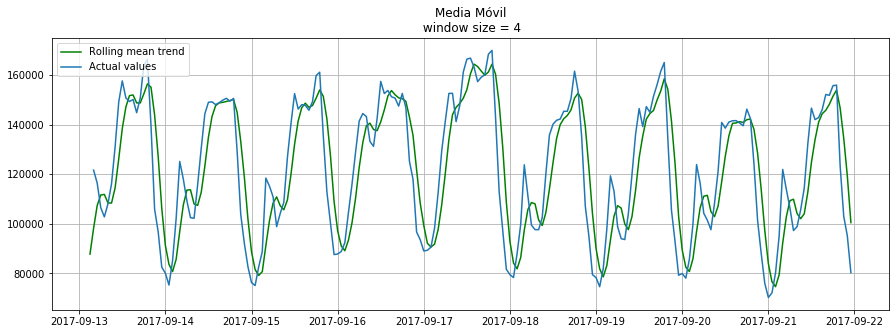

In [8]:
plotMovingAverage(ads, 4)

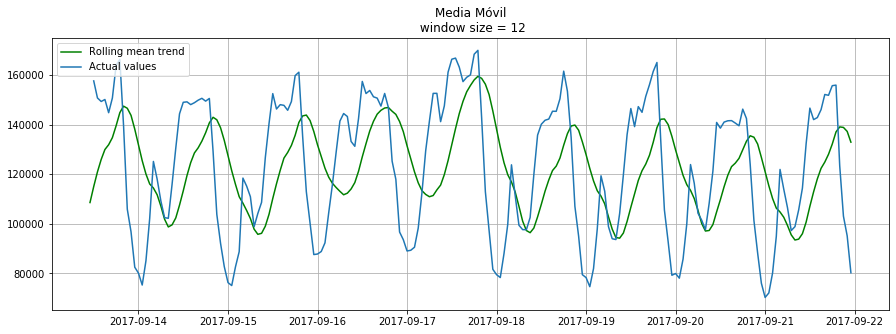

In [9]:
plotMovingAverage(ads, 12)

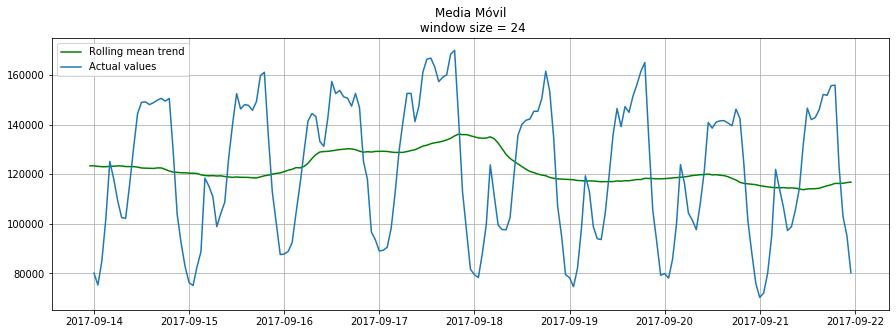

In [10]:
plotMovingAverage(ads, 24)

Al aplicar daily smoothing sobre los datos por hora podemos ver la dinámica de los anuncios vistos.
Durante los fines de semana los valores son más altos mientras que menos anuncios son vistos en los días hábiles.
También podemos agregar intervalos de confianza para la serie suavizada


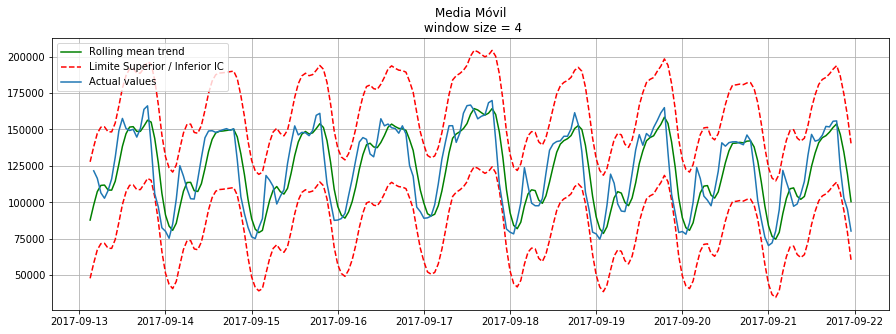

In [11]:
plotMovingAverage(ads, 4, plot_intervals=True)

Creemos un sistema simple de detección de anomalías con la ayuda del promedio móvil. Intencionalmente agregaremos un valor anormal en el dataframe.


In [0]:
ads_anomaly = ads.copy()
# say we have 80% drop of ads 
ads_anomaly.iloc[-20] = ads_anomaly.iloc[-20] * 0.2 

Veamos si este método simple puede detectar la anomalía

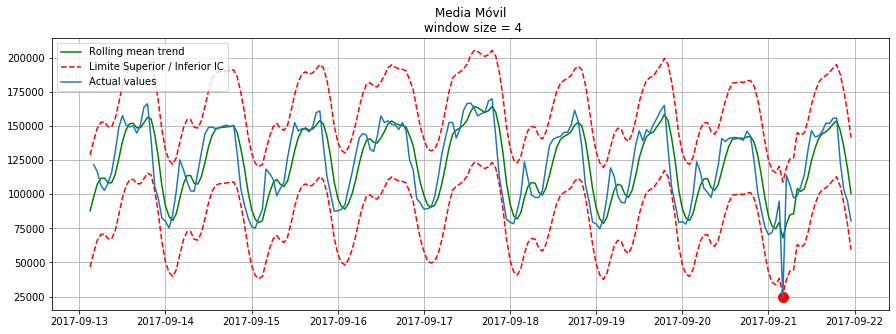

In [13]:
plotMovingAverage(ads_anomaly, 4, plot_intervals=True, plot_anomalies=True)

¿Qué pasa con la segunda serie? #weekly smoothing

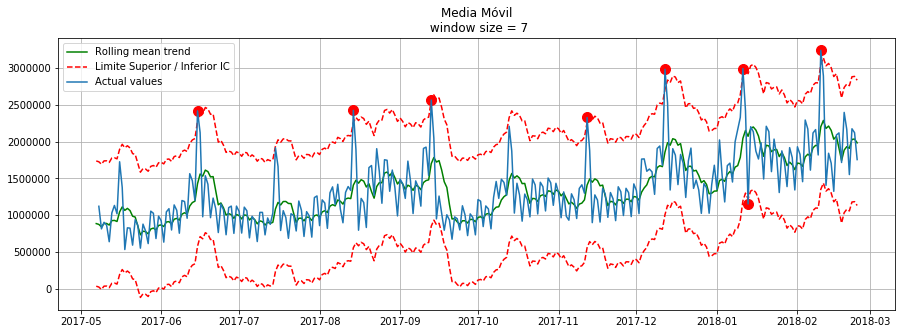

In [14]:

plotMovingAverage(currency, 7, plot_intervals=True, plot_anomalies=True) 

#### Podemos ver el donwisde de nuestro enfoque. No ha logrado capturar la estacionalidad en nuestros datos y ha marcado casi todos los picos de 30 días como anomalías. Si quiere evitar los falsos positivos, es mejor considerar  modelos más complejos.


#### El promedio ponderado es una modificación simple al moving average. Los ponderadores suman 1 con pesos más grandes asignados a las observaciones más recientes.


$$ \widehat{y}_t =  \sum_{n=1}^{k} \omega y_{t+1-n}$$

In [15]:
def weighted_average(series, weights):
    """
        Devuelve la media ponderada de la serie
    """
    result = 0.0
    weights.reverse()
    for n in range(len(weights)):
        result += series.iloc[-n-1] * weights[n]
    return float(result)
  
weighted_average(ads, [0.6, 0.3, 0.1])

98423.0

## Exponential Smoothing

#### Veamos que sucede si en lugar de ponderar los últimos $k$ valores, ponderamos todas las observaciones disponibles con ponderadores exponencialmene decrecientes a medida que nos movemos hacia atrás en el tiempo.



$$ \widehat{y_t} =\alpha . y_{t}  + (1 - \alpha ) . \widehat{y}_{t -1} $$

#### Aquí el modelo es un promedio ponderado entre el valor actual y el valor anterior del modelo. 

#### $\alpha$ se conoce como smoothing factor.


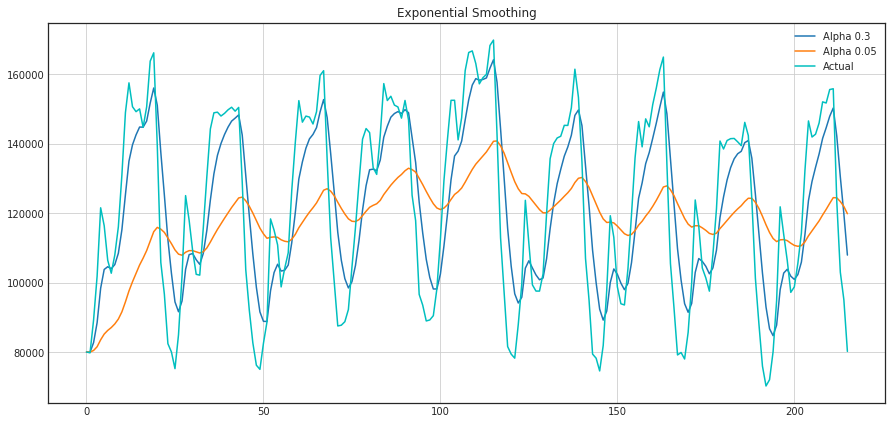

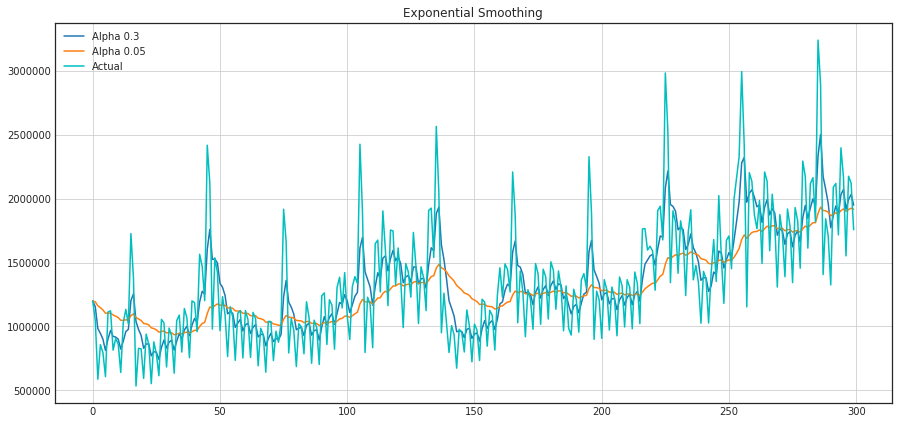

In [16]:
def exponential_smoothing(series, alpha):
    """
        series - dataset with timestamps
        alpha - float [0.0, 1.0], smoothing parameter
    """
    result = [series[0]] # first value is same as series
    for n in range(1, len(series)):
        result.append(alpha * series[n] + (1 - alpha) * result[n-1])
    return result
    
def plotExponentialSmoothing(series, alphas):
    """
        Plots exponential smoothing with different alphas
        
        series - dataset with timestamps
        alphas - lista de alphas
        
    """
    with plt.style.context('seaborn-white'):    
        
        plt.figure(figsize=(15, 7))
        
        for alpha in alphas:
            plt.plot(exponential_smoothing(series, alpha), label="Alpha {}".format(alpha))
        
        plt.plot(series.values, "c", label = "Actual")
        plt.legend(loc="best")
        plt.axis('tight')
        plt.title("Exponential Smoothing")
        plt.grid(True);
        
plotExponentialSmoothing(ads.Ads, [0.3, 0.05])
plotExponentialSmoothing(currency.GEMS_GEMS_SPENT, [0.3, 0.05])

## Double Exponential Smoothing

#### Extendamos el exponential smoothing de forma que podamos predecir dos puntos en el futuro.
#### La descompisición de la serie nos ayudará, podemos obtener dos componentes: intercepto y pendiente. Hemos aprendido a predecir el intercepto con nuestros métodos previos, ahora aplicaremos el mismo exponential smoothing a la pendiente asumiendo que la dirección futura de los cambios en la serie de tiempo depende de los cambios previos ponderados.

 $$ \mathscr{C} =\alpha . y_{x}  + (1 - \alpha ) . ( \mathscr{C}_{x-1} + b_{x-1})
 $$
 
  $$b_{x} =\beta .(\mathscr{C_{x} -\mathscr{C}_{x-1})} + (1- \beta) b_{x-1}
 $$
 
  $$\widehat{y}_{x+1} = \mathscr{C_{x}} +b_{x}
 $$
 

#### El primero describe el intercepto, que al igual que antes, depende del valor actual de la serie. El segundo término ahora se divid entre valores anteriores del nivel y de la tendencia. La segunda función describe la tendencia, que depende de los cambios en el nivel en el paso actual y en el valor anterior de la tendencia. En este caso, el coeficiente $β$ es un ponderador para exponential smoothing. La predicción final es la suma de los valores del modelo para intercepto y tendencia.


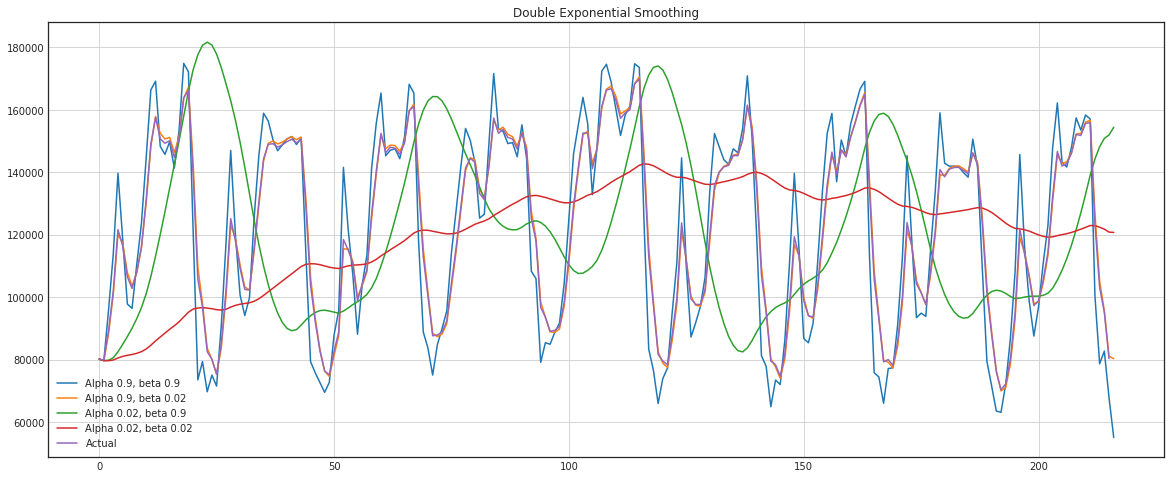

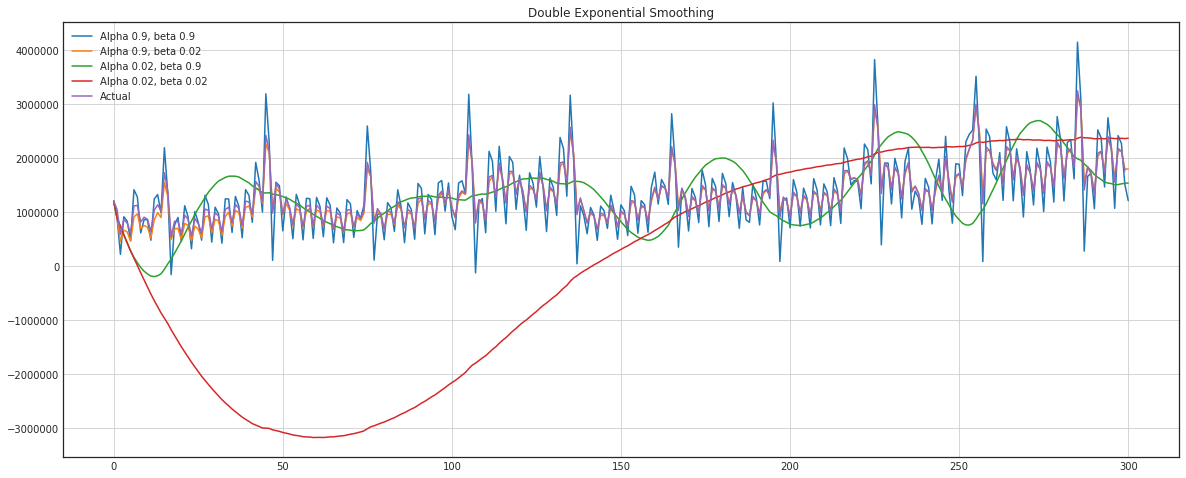

In [17]:
def double_exponential_smoothing(series, alpha, beta):
    """
        series - dataset with timeseries
        alpha - float [0.0, 1.0], smoothing parameter for level
        beta - float [0.0, 1.0], smoothing parameter for trend
    """
    # first value is same as series
    result = [series[0]]
    for n in range(1, len(series)+1):
        if n == 1:
            level, trend = series[0], series[1] - series[0]
        if n >= len(series): # forecasting
            value = result[-1]
        else:
            value = series[n]
        last_level, level = level, alpha*value + (1-alpha)*(level+trend)
        trend = beta*(level-last_level) + (1-beta)*trend
        result.append(level+trend)
    return result

def plotDoubleExponentialSmoothing(series, alphas, betas):
    """
        Plots double exponential smoothing with different alphas and betas
        
        series - dataset with timestamps
        alphas - list of floats, smoothing parameters for level
        betas - list of floats, smoothing parameters for trend
    """
    
    with plt.style.context('seaborn-white'):    
        plt.figure(figsize=(20, 8))
        for alpha in alphas:
            for beta in betas:
                plt.plot(double_exponential_smoothing(series, alpha, beta), label="Alpha {}, beta {}".format(alpha, beta))
        plt.plot(series.values, label = "Actual")
        plt.legend(loc="best")
        plt.axis('tight')
        plt.title("Double Exponential Smoothing")
        plt.grid(True)
        
plotDoubleExponentialSmoothing(ads.Ads, alphas=[0.9, 0.02], betas=[0.9, 0.02])
plotDoubleExponentialSmoothing(currency.GEMS_GEMS_SPENT, alphas=[0.9, 0.02], betas=[0.9, 0.02])

#### Ahora tenemos dos parámetros para tunear  $α$ and $β$. El primero es responsable por el smoothing de la serie alrededor de la tendencia, el último por el smoothing de la tendencia en sí misma. Cuánto más grandes los valores la observación más reciente tendrá más peso y la serie será menos suavizada.


## Triple Exponential Smoothing Holt-Winters

#### La idea es agregar un tercer componente: la estacionalidad. Esto significa que no debemos usar este método si no se espera que nuestra serie de tiempo tenga estacionalidad. Los componentes estacionales en el modelo explicarán las variaciones repetidas alrededor del intercepto y la tendencia, y se especificarán por la duración de la temporada, en otras palabras, por el período después del cual las variaciones se repiten. Para cada observación en la temporada, hay un componente separado; por ejemplo, si la duración de la temporada es de 7 días (una estacionalidad semanal), tendremos 7 componentes estacionales, uno para cada día de la semana.


#### El intercepto ahora depende del valor actual de la serie menos cualquier componente estacional correspondiente. La tendencia permanece sin cambios, y el componente estacional depende del valor actual de la serie menos el intercepto y el valor anterior del componente. Tenga en cuenta que el componente se suaviza a través de todas las temporadas disponibles; por ejemplo, si tenemos un componente de lunes, entonces solo se promediará con otros lunes. . Ahora que tenemos el componente estacional, podemos predecir no solo uno o dos pasos por delante sino también un futuro arbitrario, lo que es muy alentador.

#### A continuación se muestra el código para un modelo de suavizado exponencial triple, que también se conoce por los apellidos de sus creadores, Charles Holt y su estudiante Peter Winters. Además, el método Brutlag se incluyó en el modelo para producir intervalos de confianza:

$$ \mathscr{C} = \alpha(y_{x} -s_{x-L}) + (1-\alpha)(\mathscr{C}_{x-1} + b_{x-1}) 
$$

$$ b_{x} = \beta( \mathscr{C}_{x} - \mathscr{C}_{x-1}) +(1-\beta)b_{x-1}
$$

$$s_{x} = \gamma( y_{x} - \mathscr{C}_{x}) +(1-\gamma)s_{x-L}
$$


$$\widehat{y}_{x+m} = \mathscr{C} + mb_{x} +s_{x-L+1+(m-1)modL}
$$

$$ \widehat{y}_{max_{x}} = \mathscr{C}_{x-1} + b_{x-1} + s_{x-T} + m . d_{t-T}
$$

$$ \widehat{y}_{min_{x}} = \mathscr{C}_{x-1} + b_{x-1} + s_{x-T} - m . d_{t-T}
$$

$$ d_t = \gamma  | y_t -  \widehat{y}_t|  + (1 - \gamma) d_{t-T}
$$

<h3><center> Donde $T$ es el largo de la temporada, $d$ es la desviación pronosticada  </center></h3>

In [0]:
class HoltWinters:
    
    """
    Modelo HoltWinters con el metodo Brutlag de deteccion de anomalias
    
    # series - initial time series
    # slen   - tamaño de la temporada
    # alpha, beta, gamma - coeficientes del modelo Holt-Winters
    # n_preds - predictions horizon
    # scaling_factor - ancho del intervalo de confianza Brutlag (usualmente de 2 a 3)
    
    """
    
    
    def __init__(self, series, slen, alpha, beta, gamma, n_preds, scaling_factor=1.96):
        
        self.series = series
        self.slen   = slen
        
        self.alpha  = alpha
        self.beta   = beta
        self.gamma  = gamma
        
        self.n_preds = n_preds
        self.scaling_factor = scaling_factor
        
        
    def initial_trend(self):
        sum = 0.0
        for i in range(self.slen):
            sum += float(self.series[i+self.slen] - self.series[i]) / self.slen
        return sum / self.slen  
    
    def initial_seasonal_components(self):
        
        seasonals = {}
        season_averages = []
        n_seasons = int(len(self.series)/self.slen)
        
        # let's calculate season averages
        for j in range(n_seasons):
            season_averages.append(sum(self.series[self.slen*j:self.slen*j+self.slen])/float(self.slen))
        # let's calculate initial values
        
        for i in range(self.slen):
            sum_of_vals_over_avg = 0.0
            
            for j in range(n_seasons):
                sum_of_vals_over_avg += self.series[self.slen*j+i]-season_averages[j]
            
            seasonals[i] = sum_of_vals_over_avg/n_seasons
        
        return seasonals   

          
    def triple_exponential_smoothing(self):
        
        self.result = []
        self.Smooth = []
        self.Season = []
        self.Trend = []
        self.PredictedDeviation = []
        self.UpperBond = []
        self.LowerBond = []
        
        seasonals = self.initial_seasonal_components()
        
        for i in range(len(self.series)+self.n_preds):
            if i == 0: # components initialization
                smooth = self.series[0]
                trend = self.initial_trend()
                self.result.append(self.series[0])
                self.Smooth.append(smooth)
                self.Trend.append(trend)
                self.Season.append(seasonals[i%self.slen])
                
                self.PredictedDeviation.append(0)
                
                self.UpperBond.append(self.result[0] + 
                                      self.scaling_factor * 
                                      self.PredictedDeviation[0])
                
                self.LowerBond.append(self.result[0] - 
                                      self.scaling_factor * 
                                      self.PredictedDeviation[0])
                continue
                
            if i >= len(self.series): # predicting
                m = i - len(self.series) + 1
                self.result.append((smooth + m*trend) + seasonals[i%self.slen])
                
                # when predicting we increase uncertainty on each step
                self.PredictedDeviation.append(self.PredictedDeviation[-1]*1.01) 
                
            else:
                val = self.series[i]
                last_smooth, smooth = smooth, self.alpha*(val-seasonals[i%self.slen]) + (1-self.alpha)*(smooth+trend)
                trend = self.beta * (smooth-last_smooth) + (1-self.beta)*trend
                seasonals[i%self.slen] = self.gamma*(val-smooth) + (1-self.gamma)*seasonals[i%self.slen]
                self.result.append(smooth+trend+seasonals[i%self.slen])
                
                # Deviation is calculated according to Brutlag algorithm.
                self.PredictedDeviation.append(self.gamma * np.abs(self.series[i] - self.result[i]) 
                                               + (1-self.gamma)*self.PredictedDeviation[-1])
                     
            self.UpperBond.append(self.result[-1] + 
                                  self.scaling_factor * 
                                  self.PredictedDeviation[-1])

            self.LowerBond.append(self.result[-1] - 
                                  self.scaling_factor * 
                                  self.PredictedDeviation[-1])

            self.Smooth.append(smooth)
            self.Trend.append(trend)
            self.Season.append(seasonals[i%self.slen])

## Time Series Cross Validation 

#### Antes de comenzar a construir un modelo, veamos primero cómo estimar los parámetros del modelo automáticamente.

#### No hay nada inusual aquí; como siempre, tenemos que elegir una función de pérdida adecuada para la tarea que nos dirá qué tan cerca se aproxima el modelo a los datos. Luego, utilizando la validación cruzada, evaluaremos la función de pérdida elegida para los parámetros del modelo dados, calcularemos el gradiente, ajustaremos los parámetros del modelo, etc., eventualmente descendiendo al mínimo global.

#### Es posible que se pregunte cómo realizar una validación cruzada para series de tiempo porque las series de tiempo tienen esta estructura temporal y no se pueden mezclar los valores aleatoriamente en un pliegue mientras se conserva esta estructura. Con la aleatorización, se perderán todas las dependencias temporales entre las observaciones. Es por esto que tendremos que usar un enfoque más complicado para optimizar los parámetros del modelo. Utilizaremos es "cross validation on a rolling basis".

#### La idea es bastante simple: entrenamos nuestro modelo en un pequeño segmento de la serie de tiempo desde el principio hasta algunas t, hacemos predicciones para los siguientes t + n pasos y calculamos un error. Luego, expandimos nuestra muestra de entrenamiento a valor t + n, hacemos predicciones desde t + n hasta t + 2 ∗ n, y continuamos moviendo nuestro segmento de prueba de la serie de tiempo hasta que alcanzamos la última observación disponible. Como resultado, tenemos folds  como n cabrá entre la muestra de entrenamiento inicial y la última observación

<img src="ts_validation.png" alt="drawing" width="600"/>

#### Busquemos los parámetros óptimos para el modelo de  Holt-Winters model. Recuerden que tenemos estacionalidad diaria, por eso  fijamos el parámetro slen=24

In [0]:
from sklearn.model_selection import TimeSeriesSplit 

def timeseriesCVscore(params, series, loss_function=mean_squared_error, slen=24):
    """
        Returns error on CV  
        
        params - vector of parameters for optimization
        series - dataset with timeseries
        slen - season length for Holt-Winters model
    """
    # errors array
    errors = []
    
    values = series.values
    alpha, beta, gamma = params
    
    # set the number of folds for cross-validation
    tscv = TimeSeriesSplit(n_splits=3) 
    
    # iterating over folds, train model on each, forecast and calculate error
    for train, test in tscv.split(values):

        model = HoltWinters(series=values[train], slen=slen, 
                            alpha=alpha, beta=beta, gamma=gamma, n_preds=len(test))
        model.triple_exponential_smoothing()
        
        predictions = model.result[-len(test):]
        actual = values[test]
        error = loss_function(predictions, actual)
        errors.append(error)
        
    return np.mean(np.array(errors))


#### En el modelo de Holt-Winters, así como en los otros modelos de suavizado exponencial, existe una restricción sobre el tamaño de los parámetros de suavizado, cada uno de ellos puede tomar valores de 0 a 1. Por lo tanto, para minimizar nuestra función de pérdida debemos elegir un algoritmo que admita restricciones en los parámetros del modelo. En nuestro caso, utilizaremos el gradiente de conjugado de Newton truncado.

In [20]:
#%%time
data = ads.Ads[:-20] # leave some data for testing

# initializing model parameters alpha, beta and gamma
x = [0, 0, 0] 

# Minimizing the loss function 
opt = minimize(timeseriesCVscore, x0=x, 
               args=(data, mean_squared_log_error), 
               method="TNC", bounds = ((0, 1), (0, 1), (0, 1))
              )

# Take optimal values...
alpha_final, beta_final, gamma_final = opt.x

print(alpha_final, beta_final, gamma_final)

# ...and train the model with them, forecasting for the next 50 hours
model = HoltWinters(data, 
                    slen = 24, 
                    alpha = alpha_final, 
                    beta = beta_final, 
                    gamma = gamma_final, 
                    n_preds = 50, 
                    scaling_factor = 3)

model.triple_exponential_smoothing()

0.11681811415263998 0.002674202051183794 0.059665015439133884


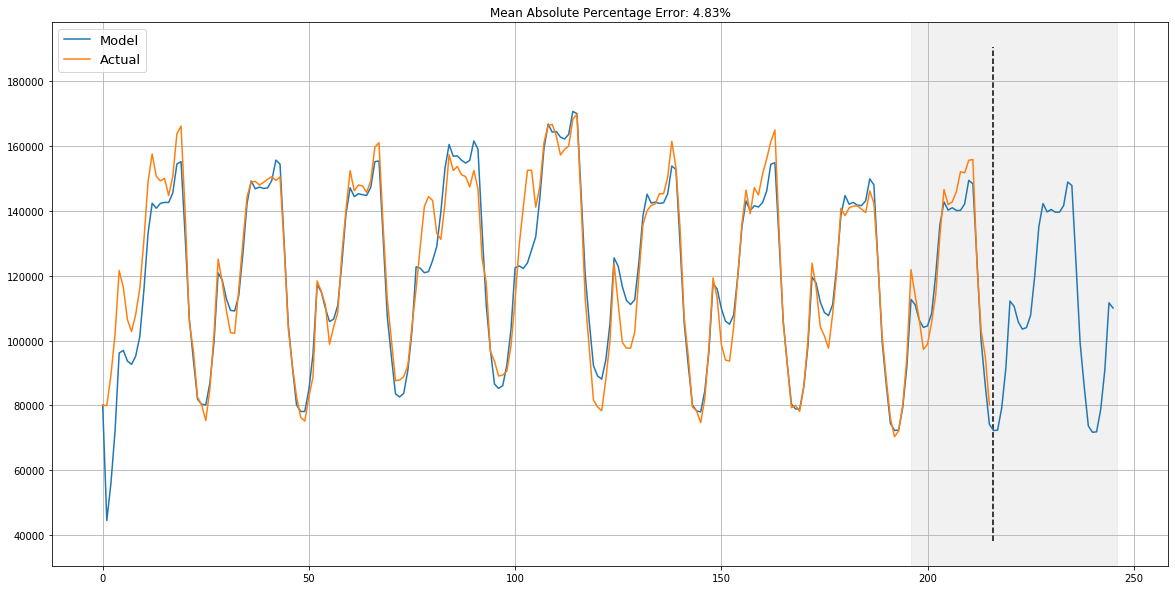

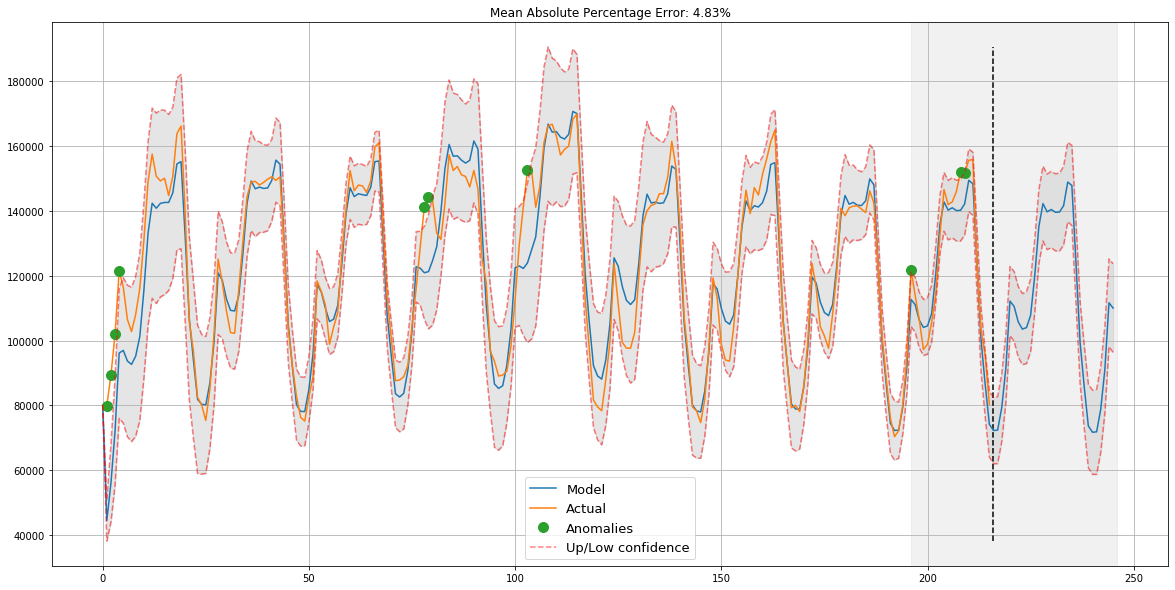

In [21]:
def plotHoltWinters(series, plot_intervals=False, plot_anomalies=False):
    """
        series - dataset with timeseries
        plot_intervals - graficar intervalos de confianza
        plot_anomalies - graficar ouliers
    """
    
    plt.figure(figsize=(20, 10))
    plt.plot(model.result, label = "Model")
    plt.plot(series.values, label = "Actual")
    error = mean_absolute_percentage_error(series.values, model.result[:len(series)])
    plt.title("Mean Absolute Percentage Error: {0:.2f}%".format(error))
    
    if plot_anomalies:
        anomalies = np.array([np.NaN]*len(series))
        anomalies[series.values<model.LowerBond[:len(series)]] = \
            series.values[series.values<model.LowerBond[:len(series)]]
        anomalies[series.values>model.UpperBond[:len(series)]] = \
            series.values[series.values>model.UpperBond[:len(series)]]
        plt.plot(anomalies, "o", markersize=10, label = "Anomalies")
    
    if plot_intervals:
        plt.plot(model.UpperBond, "r--", alpha=0.5, label = "Up/Low confidence")
        plt.plot(model.LowerBond, "r--", alpha=0.5)
        plt.fill_between(x=range(0,len(model.result)), y1=model.UpperBond, 
                         y2=model.LowerBond, alpha=0.2, color = "grey")    
        
    plt.vlines(len(series), ymin=min(model.LowerBond), ymax=max(model.UpperBond), linestyles='dashed')
    plt.axvspan(len(series)-20, len(model.result), alpha=0.3, color='lightgrey')
    plt.grid(True)
    plt.axis('tight')
    plt.legend(loc="best", fontsize=13);
    
plotHoltWinters(ads.Ads)
plotHoltWinters(ads.Ads, plot_intervals=True, plot_anomalies=True)


A juzgar por los plots, nuestro modelo pudo aproximar con éxito la serie de tiempo inicial, capturando la estacionalidad diaria, la tendencia general a la baja e incluso algunas anomalías. Si observa las desviaciones del modelo, puede ver claramente que el modelo reacciona bastante bruscamente a los cambios en la estructura de la serie, pero luego devuelve rápidamente la desviación a los valores normales, esencialmente "olvidando" el pasado. Esta característica del modelo nos permite construir rápidamente sistemas de detección de anomalías, incluso para datos de series ruidosas, sin gastar demasiado tiempo y dinero en la preparación de los datos y el entrenamiento del modelo.

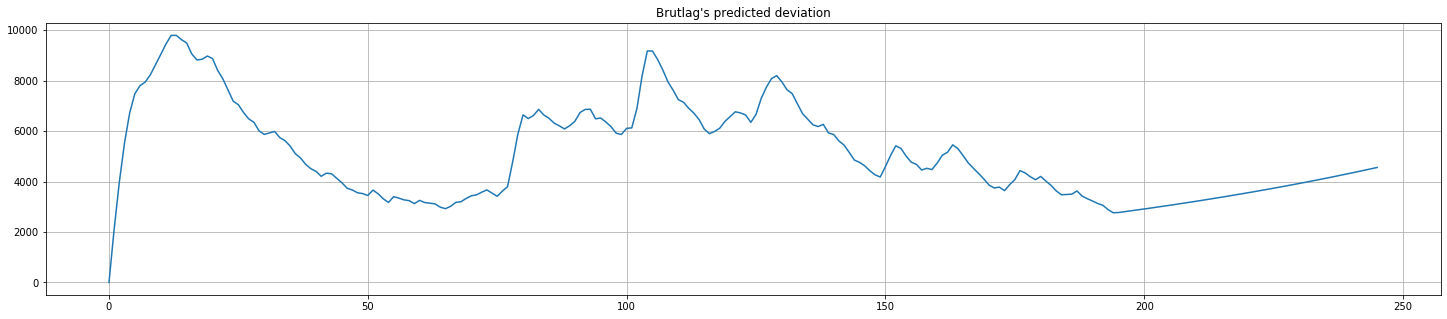

In [22]:
plt.figure(figsize=(25, 5))
plt.plot(model.PredictedDeviation)
plt.grid(True)
plt.axis('tight')
plt.title("Brutlag's predicted deviation");

#### Aplicaremos el mismo algoritmo para la segunda serie que, como puede recordar, tiene tendencia y una estacionalidad de 30 días.

In [23]:
#%%time
data = currency.GEMS_GEMS_SPENT[:-50] 
slen = 30

x = [0, 0, 0] 

opt = minimize(timeseriesCVscore, 
               x0=x, 
               args=(data, mean_absolute_percentage_error, slen), 
               method="TNC", bounds = ((0, 1), (0, 1), (0, 1))
              )

alpha_final, beta_final, gamma_final = opt.x
print(alpha_final, beta_final, gamma_final)

model = HoltWinters(data, slen = slen, 
                    alpha = alpha_final, 
                    beta = beta_final, 
                    gamma = gamma_final, 
                    n_preds = 100, scaling_factor = 3)
model.triple_exponential_smoothing()

0.012841445048055122 0.04883371471892228 0.00943678056045777


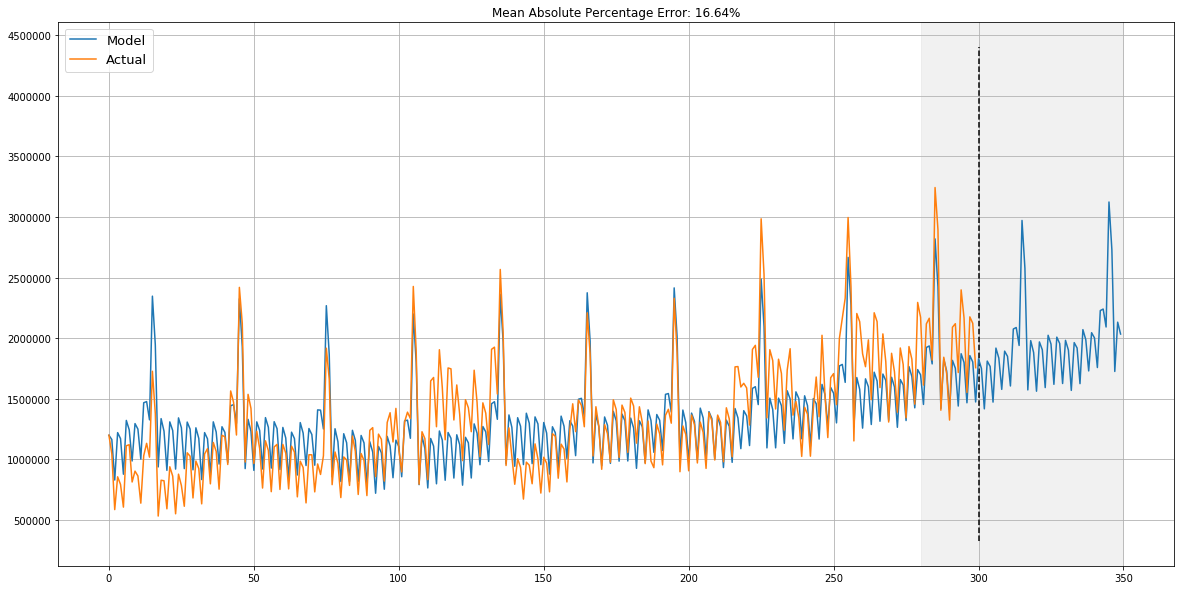

In [24]:
plotHoltWinters(currency.GEMS_GEMS_SPENT)

El modelo captó tanto la tendencia al alza como los picos estacionales y se ajusta muy bien a los datos.

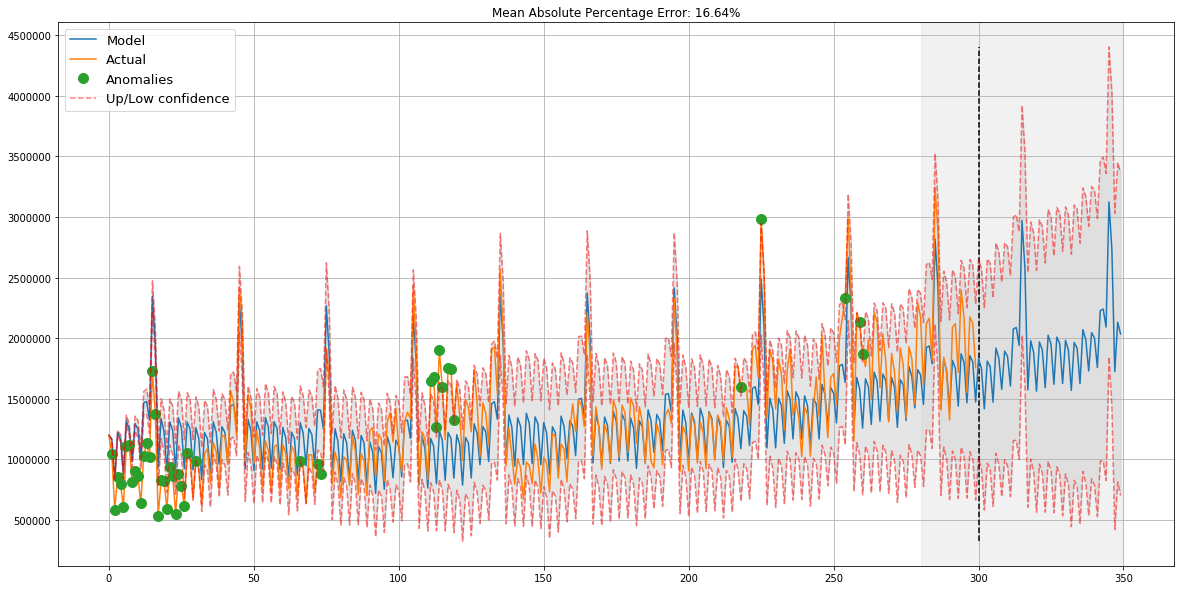

In [25]:
plotHoltWinters(currency.GEMS_GEMS_SPENT, plot_intervals=True, plot_anomalies=True)

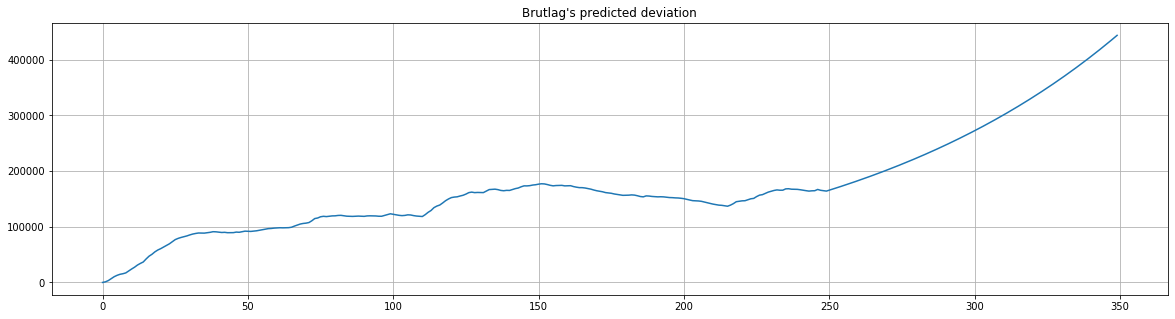

In [26]:
plt.figure(figsize=(20, 5))
plt.plot(model.PredictedDeviation)
plt.grid(True)
plt.axis('tight')
plt.title("Brutlag's predicted deviation");

In [0]:
# guardamos el df en un pickle para la proxima clase
ads.to_pickle('df_ads.pkl', compression='gzip')